In [124]:
import matplotlib.pyplot as plt
from matplotlib import mlab, rcParams
%matplotlib inline
import numpy as np
from scipy import interpolate, spatial, stats
import datetime
from shapely.geometry import Polygon, Point
import scipy.signal as signal
import pandas as pd

# TO DO:
- make sure label colours are consistent

In [ ]:
def lagcorr(data, tau):
    rho = 0.*np.array(tau)
    for ind,t in enumerate(tau):
        if t > 0:
            rho[ind] = np.nanmean(data[t:]*data[:-t])  # nanmean necessary?
            rho[ind] = rho[ind] / np.nanvar(data[t:-t])  # nanvar?
        else:
            rho[ind] = np.nanmean(data*data)
            rho[ind] = rho[ind] / np.nanvar(data)
    return rho

# Minute data

Temperature data with one-minute resolution is provided from four schools in the format of decimal days as discussed below and the second column is temperature in degrees Celcius.

Present the data, and characterize it using techniques discussed in class. Obvious things to do are just plot the time series, find means, PDFs, spectra. More involved projects will present correlations between the different stations (thats why you have 4!). What differences and patterns can you find between the four stations, and can you explain using your knowledge of the local climate?

In [55]:
# Minute data, 4 Schools
mins, dc = np.loadtxt('/Users/kawebb/P411_git/MinuteData/DeepCoveNew.txt', unpack=True)
jb = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JamesBayNew.txt', usecols=([1]), unpack=True)
jm = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JohnMuirNew.txt', usecols=([1]), unpack=True)
uv = np.loadtxt('/Users/kawebb/P411_git/MinuteData/UVicISCNew.txt', usecols=([1]), unpack=True)

### Linear interpolation

In [56]:
# fill in nan values with linear interpolation

def interp(data, rmean=False):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    if rmean:
        data -= np.mean(data)  # remove mean
    return data

dc = interp(dc, rmean=True)
jb = interp(jb, rmean=True)
jm = interp(jm, rmean=True)
uv = interp(uv, rmean=True)

/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


### Time series

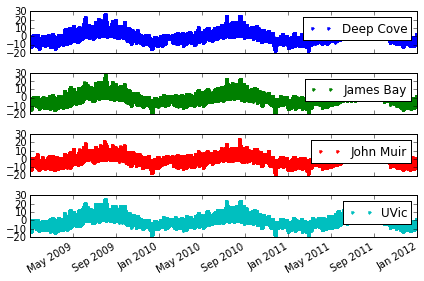

In [59]:
#latexify(columns=2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)#, figsize=(10,5))

ldc = ax1.plot_date(mins, dc, color='b', label='Deep Cove', marker='.') ; ax1.legend()
ljb = ax2.plot_date(mins, jb, color='g', label='James Bay', marker='.') ; ax2.legend()
ljm = ax3.plot_date(mins, jm, color='r', label='John Muir', marker='.') ; ax3.legend()
luv = ax4.plot_date(mins, uv, color='c', label='UVic', marker='.') ; ax4.legend()

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig('figures/min_timeseries.png')

#fig = plt.figure()
#ax = fig.add_subplot(111)    # The big subplot
# Turn off axis lines and ticks of the big subplot
#ax.spines['top'].set_color('none')
#ax.spines['bottom'].set_color('none')
#ax.spines['left'].set_color('none')
#ax.spines['right'].set_color('none')
#ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
# Set common labels
#ax.set_ylabel(r'Temperature [$^\circ$C]')
#plt.savefig('figures/temp_label.png')

There seems to be a lot of noise due to daily fluctuations that obscure the yearly patterns. This can be improved by filtering the data with an elliptical low pass filter, with a stopband of ~ 3.5/day

### Low-pass filter

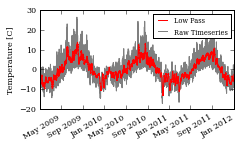

In [49]:
### Low-pass filter to see yearly patterns and suppress daily correlations
latexify(columns=1)

ts = 60.*24

def low_pass(data, ts, stopband=3.5):
    df = 1./(stopband*ts)
    wp = 0.7*df
    ws = 0.9*df
    n, fn = signal.ellipord(wp, ws, 0.5, 20.)
    b, a = signal.ellip(n, 0.5, 20., fn)
    fdata = signal.lfilter(b, a, data)
    #f = signal.filtfilt(b,a,dc)
    return fdata

fdc = low_pass(dc, ts)

fig, ax = plt.subplots(1,1)
ax.plot_date(mins, fdc, 'r-', zorder=1, label='Low Pass')
ax.plot_date(mins, dc, 'k-', alpha=0.5, zorder=0, label='Raw Timeseries')
ax.legend(loc=0,fontsize='small')
ax.set_ylabel('Temperature [C]')
fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig('figures/min_lowpass.png')

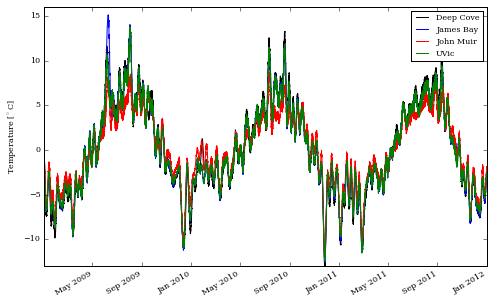

In [129]:
#latexify(columns=2)
fjb = low_pass(jb, ts)
fjm = low_pass(jm, ts)
fuv = low_pass(uv, ts)

fig, ax = plt.subplots(1,1)

ax.plot_date(mins, fdc, 'k-', zorder=1, label='Deep Cove')
ax.plot_date(mins, fjb, 'b-', zorder=1, label='James Bay')
ax.plot_date(mins, fjm, 'r-', zorder=1, label='John Muir')
ax.plot_date(mins, fuv, 'g-', zorder=1, label='UVic')

ax.legend()
ax.set_ylabel(r'Temperature [$^\circ$C]')
fig.autofmt_xdate()
plt.ylim(-13, 16)
plt.tight_layout()
#plt.savefig('figures/min_lowpassall.png')

With the time series smoothed, the temperature difference between summer and winter is much more obvious, as is expected for more nothern latitudes. 

It also seems that John Muir is consistnetly cooler in the summer than the other locations, and warmer in the winter. 
** Look at the at the pdfs of the yearly temperature data, calculate the univariate statistics to confirm this. **

### Probability density functions

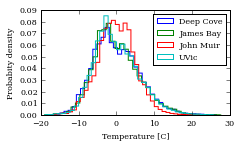

In [55]:
latexify(columns=1)

bins=40

fig, ax = plt.subplots(1,1)
ax.hist(dc, bins, normed=True, histtype='step', label='Deep Cove')
ax.hist(jb, bins, normed=True, histtype='step', label='James Bay')
ax.hist(jm, bins, normed=True, histtype='step', label='John Muir')
ax.hist(uv, bins, normed=True, histtype='step', label='UVic')

ax.legend(loc=1,fontsize='8')
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Probabity density')

plt.tight_layout()
plt.savefig('figures/min_pdf.png')

Deep cove, James bay, UVic all look very similar, with asymmetrical PDFs, leaning towards colder temperatures. John Muir seem to have a much more symmetric PDF

### Univaritate statistics

In [84]:
### REIMPORT DATA to make sure mean not subtracted
#dc = interp(dc, rmean=False)
#jb = interp(jb, rmean=False)
#jm = interp(jm, rmean=False)
#uv = interp(uv, rmean=False)

print 'Station & Mean & Stdev & Skew & Kurtosis \\\\'
data = [dc, jb, jm, uv]
labels = ['Deep Cove', 'James Bay', 'John Muir', 'UVic']
for i,datum in enumerate(data):
    print '{} & {} & {} & {} & {} \\\\'.format(
        labels[i], np.mean(datum), np.std(datum), stats.skew(datum), stats.kurtosis(datum))

Station & Mean & Stdev & Skew & Kurtosis \\
Deep Cove & 10.3016300448 & 5.98099047791 & 0.443614320919 & 0.132772732286 \\
James Bay & 10.3107251853 & 5.83675368414 & 0.480090212186 & 0.228559531715 \\
John Muir & 9.11998334356 & 4.8364971532 & 0.0638702008621 & 0.140581890246 \\
UVic & 10.2371553568 & 5.70055093019 & 0.491206670657 & 0.287881662199 \\


The mean temperatuer of John Muir is in fact lower, and with a smaller mean and much smaller skew, which agress with the differences in the PDFs

### Power spectra and cross correlation

In [60]:
### Power spectral density
Nfft = 2048*12
dt = 60.
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

def specdensity(x, args, y=None):
    px, f = mlab.psd(x, **args)
    if y is not None:
        py, f = mlab.psd(y, **args)
        pxy, ff = mlab.csd(x, y, **args)
        return px, py, pxy, f
    else:
        return px, f
    
Pdc, Pjb, Pdcjb, f = specdensity(dc, args, jb)
Pjm, Puv, Pjmuv, f = specdensity(jm, args, uv)

### Cross spectral density

Pdcjm, ff = mlab.csd(dc, jm, **args)
Pdcuv, ff = mlab.csd(dc, uv, **args)
Pjbjm, ff = mlab.csd(jb, jm, **args)
Pjbuv, ff = mlab.csd(jb, uv, **args)

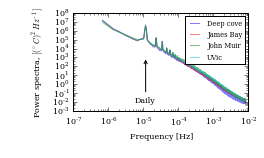

In [146]:
#latexify(columns=1)

yr = 3600.*24.*365.
day = 3600.*24.

#plt.axvline(1./day, color='k', ls=':')
plt.loglog(f, np.abs(Pdc), '-b', label='Deep cove', alpha=0.5)
plt.loglog(f, np.abs(Pjb), '-r', label='James Bay', alpha=0.5)
plt.loglog(f, np.abs(Pjm), '-g', label='John Muir', alpha=0.5)
plt.loglog(f, np.abs(Puv), '-c', label='UVic', alpha=0.5)
plt.xlabel('Frequency [Hz]') ; plt.ylabel('Power spectra, $[(^\circ C)^2 Hz^{-1}]$')
plt.legend(loc=1, fontsize='small')

plt.annotate('Annual', xy=(1./yr, 1.e3),  xycoords='data', xytext=(1./yr, 1.e-2), 
             textcoords='data', horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.annotate('Daily', xy=(1./day, 1.e3),  xycoords='data', xytext=(1./day, 1.e-2), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
#plt.savefig('figures/min_powspec.png')

# We see a clear daily signal in the spectrum, and likely an annual signal too. 
# The spikes at higher frequencies are at harmonics of the daily frequency, and 
# are due to the fact that the temperature signal is not a precise sine-wave.

### hanning window doesnt sample low frequency, which is why you dont see the yearly peak

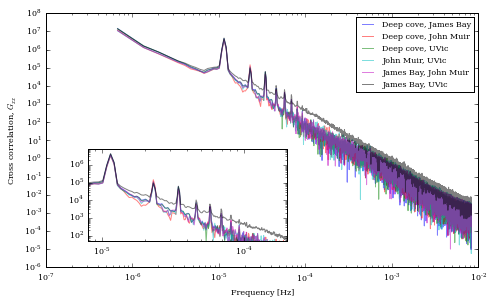

In [127]:
### REplot with inset of zoomed in region around peaks
latexify(columns=2)

# main axis
plt.loglog(f, np.abs(Pdcjb), '-b', label='Deep cove, James Bay', alpha=0.5)
plt.loglog(f, np.abs(Pdcjm), '-r', label='Deep cove, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pdcuv), '-g', label='Deep cove, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjmuv), '-c', label='John Muir, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjbjm), '-m', label='James Bay, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pjbuv), '-k', label='James Bay, UVic', alpha=0.5)
plt.xlabel('Frequency [Hz]') ; plt.ylabel('Cross correlation, $G_{xx}$')
plt.legend()
plt.tight_layout()

# this is an inset axes over the main axes
rect = [.18, .21, .4, .3]  # [left, bottom, width, height]
a = plt.axes(rect, axisbg='w')
plt.loglog(f, np.abs(Pdcjb), '-b', label='Deep cove, James Bay', alpha=0.5)
plt.loglog(f, np.abs(Pdcjm), '-r', label='Deep cove, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pdcuv), '-g', label='Deep cove, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjmuv), '-c', label='John Muir, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjbjm), '-m', label='James Bay, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pjbuv), '-k', label='James Bay, UVic', alpha=0.5)
plt.xlim(8e-6,2e-4) ; plt.ylim(5e1, 8e6)
#plt.xticks([]) ; plt.yticks([])  # Removes labels on the inset

plt.savefig('figures/min_crosscorr.png')

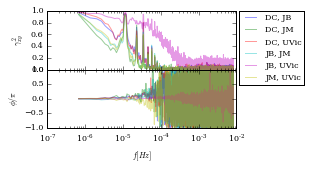

In [113]:
#latexify()

gammasq_dcjb = np.abs(Pdcjb)**2/(Pdc*Pjb)
gammasq_dcjm = np.abs(Pdcjm)**2/(Pdc*Pjm)
gammasq_dcuv = np.abs(Pdcuv)**2/(Pdc*Puv)
gammasq_jbjm = np.abs(Pjbjm)**2/(Pjm*Pjb)
gammasq_jbuv = np.abs(Pjbuv)**2/(Puv*Pjb)
gammasq_jmuv = np.abs(Pjmuv)**2/(Pjm*Puv)

gamma = [gammasq_dcjb, gammasq_dcjm, gammasq_dcuv, gammasq_jbjm, gammasq_jbuv, gammasq_jmuv]
Ccs = [Pdcjb, Pdcjm, Pdcuv, Pjbjm, Pjbuv, Pjmuv]
labels=['Deep cove, James Bay', 'Deep cove, John Muir', 'Deep Cove, UVic', 'James Bay, John Muir', 
        'James Bay, UVic', 'John Muir, UVic']
labels2=['DC, JB', 'DC, JM', 'DC, UVic', 'JB, JM', 
        'JB, UVic', 'JM, UVic']

gl = np.empty(6)
pl = np.empty(6)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True)
for i,g in enumerate(gamma):
    gl = ax1.semilogx(f, g, alpha=0.4, label=labels2[i])
    phase = np.angle(Ccs[i])
    pl = ax2.semilogx(f, phase/np.pi, alpha=0.4,)
    
ax1.set_ylabel('$\gamma^2_{xy}$') ; ax1.set_xlabel('$f [Hz]$')
plt.subplots_adjust(hspace=0)
ax2.set_ylabel('$\phi/\pi$') ; ax2.set_xlabel('$f [Hz]$')
ax1.legend(bbox_to_anchor=[1.38, 1.07])
#plt.savefig('figures/min_cohphase.png')

# Hourly data

Then use this data set to look for spatial patterns of variability between the stations (i.e. calculate the Emperical Orthonormal Eigienfunctions, or Principal Components). Plot the strongest modes of variability and indicate what fraction of the variance they represent. Plotting time series of the modal amplitudes is also very effective way of thinking about the system.

Again, spend a couple of paragraphs explaining the patterns you found, and indicate if those patterns might have a physical meaning. Looking at the seasonality of the amplitudes may help.

## ideas:
- temperature differences inland vs coasts, seasonal
- seasonal variances
- east west
- yearly fluctuations
- interpolated missing data points from nearest neighbours

### power spactra
- correlations every 24h, 1yr etc
  - combine spectra to reduce noise and get  clearer peak
  - bandpass filtering
- variation in temperature (amplitude) varies more in summer than winter
- average summer temperature, winter, yearly -> linear equation, fit to majority of data

### to keep in mind:
- more data on coast than inland, how to keep track of percision?


In [2]:
# Coastline
# 1 degree of latitude is 60 nautical miles, but 1 degree of longitude is only 60*cos(lat) 
# nautical miles, so it is useful to scale your x and y axis so the aspect ratio is 
# [1 cos(lat)], where "lat" is some latitude that is on the center of your plot. This area 
# is small enough that this approximation will be good enough - for larger areas you need 
# to choose a projection from a sphere onto a map (i.e. the "Mercator", "Azimuthal" etc projections).
coastfile = '/Users/kawebb/P411_git/Coast.txt'  # longitudes followed by latitudes
coasts = np.loadtxt(coastfile)
cstlng = coasts[:len(coasts)/2]
cstlat = coasts[len(coasts)/2:]

In [148]:
# Hourly data, many stations
# One-hour resolution temperature data is taken from the same network of 35 stations. 
# Data is on an even time grid, from 2009-01-01 08:00 UTC, with each row representing 
# a time, and each column a station. The first two rows are the longitude (degrees E) 
# and latitude (degrees N) of each station.
hourfile = '/Users/kawebb/P411_git/AllHourly.txt'
hourdata = np.loadtxt(hourfile)
data = hourdata[:,2:]
lng = hourdata[:,:1][:,0] - 360.  # -360 to fix that stations (0 to 360), coast (-180, 180).
lat = hourdata[:,1:2][:,0]

In [4]:
### Make hour data
# The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333.
d = datetime.date(2012,1,1)
tstart = 733408.333
hours = np.arange(tstart, tstart+len(data[0])/24., 1./24.)  # step size is every hour
d.fromordinal(int(hours[0])), d.fromordinal(int(hours[-1]))  # three years worth of data

### First three measurements for all stations are nan, remove
data = data[:,3:]
hours = hours[3:]

### Handling nan values, identifying stations with not enough data

/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/kawebb/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


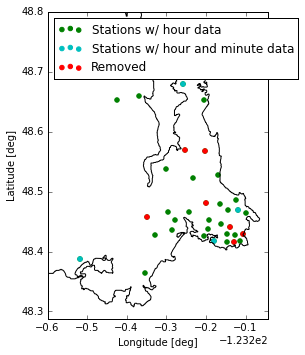

In [5]:
### Plot stations, label those with hour data, minute data, and which we remove

#latexify(columns=1)
fig, axs = plt.subplots(1,1, figsize=(5,5))
axs.plot(cstlng, cstlat, '-k')
axs.scatter(lng, lat, marker='o', color='g', label='Stations w/ hour data')
i=[6, 15, 14, 32]
axs.scatter(lng[i], lat[i], marker='o', color='c', label='Stations w/ hour and minute data')
ix = [0, 11, 16, 19, 22, 23, 34]
axs.scatter(lng[ix], lat[ix], marker='o', color='r', label='Removed')

axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'Latitude [deg]')
axs.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
axs.set_ylim(np.min(cstlat)-0.02, 48.8)
axs.set_aspect(1/np.cos(48.6*np.pi/180.))
plt.tight_layout()
plt.legend(loc=2)
#plt.savefig('figures/map_stations.png')
plt.show()

In [6]:
### Ignore data missing long spans of time

# 0, 11, 16, 19, 22, 23, 34 - missing lots
# 8, 10, 14, 17, 25, 30, 31 - missing a few months maybe

# Valid stations
ii = range(1,11)+range(12,16)+range(17,19)+range(20,22)+range(24,34)
data = data[ii,:]
lng = lng[ii]
lat = lat[ii]

tree = spatial.KDTree(zip(lng.ravel(), lat.ravel()))
radius = 0.05  # in degrees
coords = np.dstack([lng, lat])[0]

def interp(data):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

def interp_nn(data, coords, tree, radius, rmean=False):
    
    # Nearest neighbour search for interpolation
    # replace value with average of neighbours
    # MAKE SURE TO ADJUST WEIGHTING TO NEAREST NEIGHBOURS **********

    for i in range(data.shape[0]):  # iterate through stations      
        idxs = tree.query_ball_point(coords[i], radius)
        if len(idxs) < 1:
            print 'STOP'
        nearby = data[idxs]
        nans = np.where(np.isnan(data[i]))
        for j in nans[0]:
            data[i,j] = np.nanmean(nearby[:,j])
        nans = np.where(np.isnan(data[i]))
        if len(nans) > 0:
            data[i,:] = interp(data[i,:])
        if rmean:
            data[i,:] -= np.mean(data[i,:])
    return data

data = interp_nn(data, coords, tree, radius, rmean=False)

/Users/kawebb/venv/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


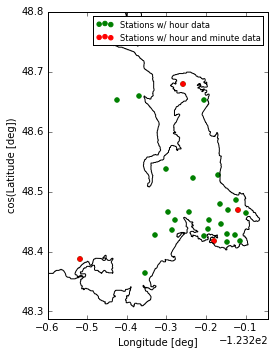

In [7]:
#latexify()
fig, axs = plt.subplots(1,1, figsize=(5,5))
axs.plot(cstlng, cstlat, '-k')
axs.scatter(lng, lat, marker='o', color='g', label='Stations w/ hour data')
i = [5, 12, 13, 26]  # deep cove, james bay, john muir, uvic
axs.scatter(lng[i], lat[i], marker='o', color='r', label='Stations w/ hour and minute data')

axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'cos(Latitude [deg])')
axs.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
axs.set_ylim(np.min(cstlat)-0.02, 48.8)
axs.set_aspect(1/np.cos(48.6*np.pi/180.))
plt.tight_layout()
plt.legend(fontsize='small')
#plt.savefig('map_stations.png')
plt.show()

<matplotlib.colorbar.Colorbar instance at 0x10b993c68>

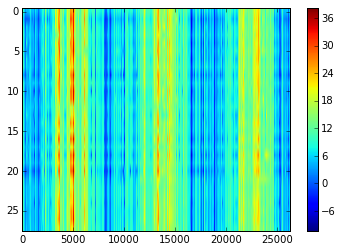

In [8]:
plt.imshow(data, aspect='auto')
plt.colorbar()

## 2D Interpolations

### Import mask to remove values over water. Fix incorrect values.

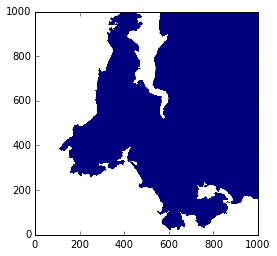

In [11]:
mask = np.loadtxt('coastline_mask2.txt')  # array of 1's and nan's. switch values.
mask[np.isnan(mask)] = 0.              
mask[np.where(mask > 0.)] = np.nan
mask[~np.isnan(mask)] = 1. 
               
plt.imshow(mask, origin='lower')

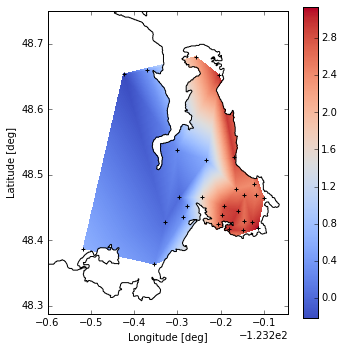

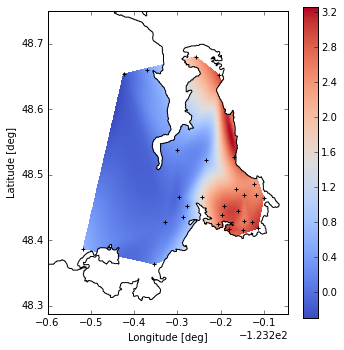

In [46]:
#latexify()

# Make grid - Smallest distance between points is lateral, 0.234 deg
# np.meshgrid makes a MxN array out of x (N-vector) and y (M-vector)
xi = np.linspace(-123.2, -123.8, 1000)
yi = np.linspace(48.3, 48.7, 1000)
gridx, gridy = np.meshgrid(xi, yi)

z = data[:,1]  # one measurement for all stations

def temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, temp, mask=None):
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    axs.plot(cstlng, cstlat, '-k')
    if mask is not None:
        gridx = gridx*mask
        gridy = gridy*mask
    pcm = plt.pcolormesh(gridx, gridy, np.ma.masked_invalid(temp), cmap='coolwarm')
    axs.scatter(lng, lat, marker='+', color='k')
    axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'Latitude [deg]')
    axs.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
    axs.set_ylim(np.min(cstlat)-0.02, 48.75)
    axs.set_aspect(1/np.cos(48.6*np.pi/180.))
    plt.colorbar()
    plt.tight_layout()
    return fig
    
zi = mlab.griddata(lng, lat, z, xi, yi, interp='linear')
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi, mask)
plt.show()

# NN interpolation wont work because grid not regular monotonically increasing
#zi = mlab.griddata(lng, lat, z, xi, yi, interp='nn')
#temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi, mask)

zi = interpolate.griddata(np.vstack((lng,lat)).T, z, (gridx,gridy), method='cubic')
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi, mask)
plt.show()

### Annual, Winter, Summer mean temperatures

In [48]:
zi_mean = interpolate.griddata(np.vstack((lng,lat)).T, np.mean(data, axis=1), (gridx,gridy), method='cubic')

season = 24*30*3
year = 24*356

data_winter = np.hstack([data[:,:season], data[:,year:season+year], data[:,2*year:2*(season+year)]])
data_summer = np.hstack([data[:,2*season:3*season], data[:,year+2*season:3*season+year], 
                         data[:,2*year+2*season:3*season+2*year]])

zi_winter = interpolate.griddata(np.vstack((lng,lat)).T, np.mean(data_winter, axis=1), (gridx,gridy), method='cubic')
zi_summer = interpolate.griddata(np.vstack((lng,lat)).T, np.mean(data_summer, axis=1), (gridx,gridy), method='cubic')

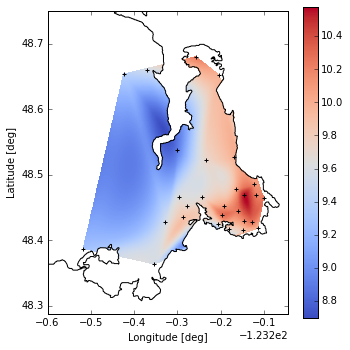

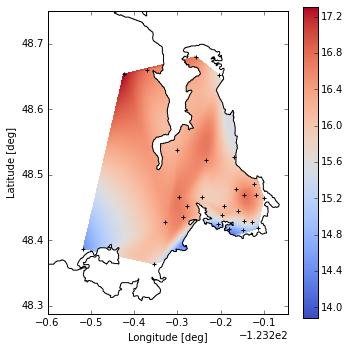

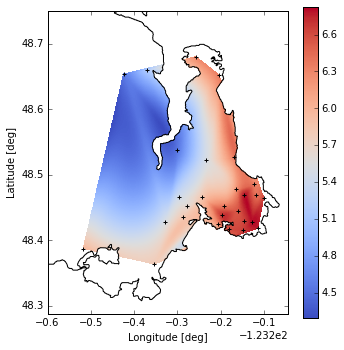

In [51]:
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_mean, mask)
#plt.savefig('figures/hour_meanannual.png')
plt.show()
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_summer, mask)
#plt.savefig('figures/hour_meansummer.png')
plt.show()
temp_plot(lng, lat, cstlng, cstlat, gridx, gridy, zi_winter, mask)
#plt.savefig('figures/hour_meanwinter.png')
plt.show()

### El Nino, el Nina - both moderate during this time
http://ggweather.com/enso/oni.htm

### Power spectral density

In [52]:
### Power spectral density
### Cross spectral density

#Nfft = 2048*2
Nfft = np.shape(data)[1]/24
dt = 60.*60.   # Assignment 4 uses 60*60
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

fps = np.zeros((data.shape[0], Nfft/2+1))
ps = np.zeros((data.shape[0], Nfft/2+1))
for i in range(data.shape[0]):
    ps[i,:], fps[i,:] = mlab.psd(data[i,:], **args)
    
#Pdcjm, ff = mlab.csd(dc, jm, **args)

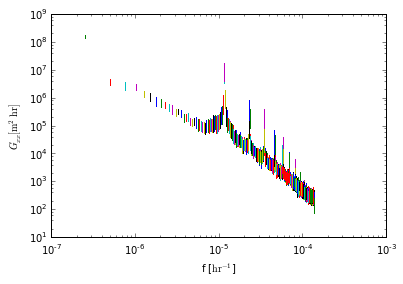

In [53]:
fig,ax=plt.subplots(1,1)
ax.loglog(fps[:,:], np.abs(ps)[:,:])
plt.xlabel('f [$\mathrm{hr^{-1}}$]');
plt.ylabel(r'$G_{xx} \mathrm{[m^2 hr]}$')

## Look for spatial patterns in the data using empiracle orthogonal functions

### 2d plot temperature as modes

In [ ]:
y = data

C = np.cov(y.T)
Cp, E = np.linalg.eig(C)

for i in range(np.shape(E)[1]):
    ii = np.argmax(np.abs(E[:,i]))
    E[:,i]=E[:,i]/E[ii,i]
E = E / np.max(np.abs(E),axis=0)
modes=np.dot(np.linalg.inv(E),y)


def plotit():
    fig,ax=plt.subplots(1,1)
    col=['b','g','r','c']
    for m in range(4):
        ax.plot(x,E[:,m],label='mode %d'%m,color=col[m])
    ax.legend(fontsize='small')
    plt.title('Mode shapes')
    plt.xlabel('x [m]')
    plt.ylabel('Emperical Mode shape')
    return fig,ax


In [ ]:
modes

## Spectrogram

/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


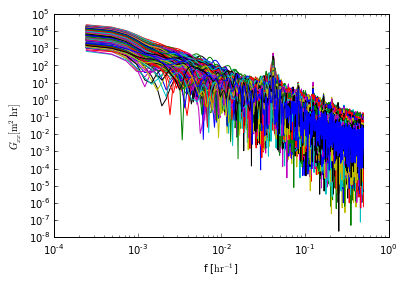

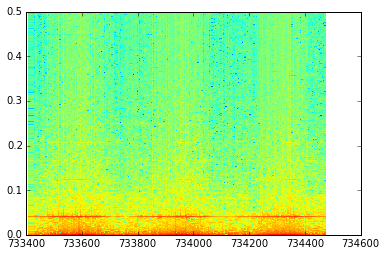

In [106]:
N = data.shape[1]
t = np.arange(N)
dt2 = np.median(np.diff(t))
NN = 24.  # This is just the window size, for small window size, remove high f ?
n = int(np.floor(N/NN))
nn = 10.  # arbitrarily chosen, same as notes

gxx = np.zeros((N*nn, Nfft/2+1))
tbin = np.zeros(N*nn)

num = 0

temp = data[0,:]
args2 = {'NFFT':Nfft, 'Fs':1./dt2, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

for idx in np.arange(0, N-n, int(np.floor(n/nn))):
    px, f = np.squeeze( mlab.psd(temp[idx+np.arange(n)], **args2))
    gxx[num,:] = px
    num += 1
    tbin[num] = np.mean(t[idx+np.arange(n)])

tbin = tbin[:num]
gxx = gxx[:num, :]

fig,axs = plt.subplots(1,1)
axs.loglog(f, gxx.transpose())
axs.set_xlabel('f [$\mathrm{hr^{-1}}$]')
axs.set_ylabel(r'$G_{xx} \mathrm{[m^2 hr]}$')
plt.show()

fig,axs = plt.subplots(1,1)
pcm = axs.pcolormesh(tbin/24.+733408.0, f, np.log10(gxx.transpose()))
plt.show()

In [108]:
np.shape(hours), np.shape(data), np.shape(ps), np.shape(f)

((26277,), (28, 26277), (28, 2049), (2049,))

In [112]:
26277./24., np.shape(data)[1]

(1094.875, 26277)

TypeError: Dimensions of C (28, 2049) are incompatible with X (26277) and/or Y (2049); see help(pcolormesh)

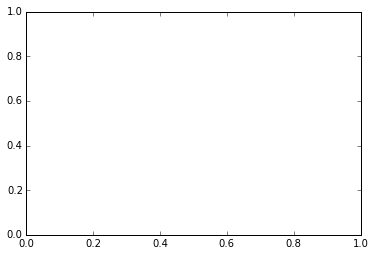

In [107]:
pcm = plt.pcolormesh(hours, f, np.log10(ps))
plt.show()

In [ ]:
### Lag correlation coefficient - Assignment 3

lag = np.arange(0,30*24)

rho = lagcorr(dc, lag)

x = lag/24.
plt.plot(x, rho)
plt.xlabel(r'$\tau [days]$') ; plt.ylabel(r'$\rho_{xy}(\tau)$') ; plt.show()

# There is a strong daily correlation, superimposed on a longer time scale 
#  weakening of the correlation as time gets further out.

# Do the same for winter and summer months

## School locations data

In [130]:
slat = []
slng = []
selv = []
sn = []

with open('schools.txt') as infile:
    next(infile)
    for i,line in enumerate(infile):
        lines = line.split()
        selv.append(float(lines[-1]))
        slng.append(float(lines[-2]))
        slat.append(float(lines[-3]))
        sn.append(float(lines[0]))

In [163]:
sch = pd.read_table('schools_parsed.txt', sep=',')
schs = sch.sort(' Latitude')
print schs.head()
for i in schs.index:
    print '{} & {} & {} & {} \\\\'.format(schs['school'][i],schs[' Latitude'][i], schs[' Longitude'][i], schs[' Elevation'][i])

                                 school   Latitude   Longitude   Elevation
9       Hans Helgesen Elementary School    48.3640    -123.554         103
30                Journey Middle School    48.3874    -123.717          39
22  Sir James Douglas Elementary School    48.4153    -123.348          20
34            Marget Jenkins Elementary    48.4161    -123.330          25
10          James Bay Elementary School    48.4169    -123.380           8
Hans Helgesen Elementary School & 48.364 & -123.554 & 103 \\
Journey Middle School & 48.3874 & -123.717 & 39 \\
Sir James Douglas Elementary School & 48.4153 & -123.348 & 20 \\
Marget Jenkins Elementary & 48.4161 & -123.33 & 25 \\
James Bay Elementary School & 48.4169 & -123.38 & 8 \\
Monterey Elementary School & 48.4182 & -123.314 & 13 \\
Dunsmuir Middle School & 48.4191 & -123.488 & 81 \\
MacAulay Elementary School & 48.4253 & -123.405 & 25 \\
Sundance Elementary School & 48.4275 & -123.328 & 29 \\
The AChannel Studio & 48.4281 & -123.366 & 1

## Suggestions

- write a hypothesis
  - apply techniques to prove hypothesis
- plot a power spectrum to find a peak



In [104]:
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """
    assert(columns in [1,2])
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches
    if fig_height is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES
    params = {'backend': 'ps',
              #'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              #'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }
    rcParams.update(params)
    
def format_axes(ax, xlabel, ylabel):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
    return ax